In [14]:
import tensorflow as tf
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import os.path
#import keras
tf.reset_default_graph()

In [15]:
# 랜덤에 의해 똑같은 결과를 재현하도록 시드 설정
# 하이퍼파라미터를 튜닝하기 위한 용도(흔들리면 무엇때문에 좋아졌는지 알기 어려움)
tf.set_random_seed(777)

In [16]:
# 너무 작거나 너무 큰 값이 학습을 방해하는 것을 방지하고자 정규화한다
# x가 양수라는 가정하에 최소값과 최대값을 이용하여 0~1사이의 값으로 변환
# Min-Max scaling
def min_max_scaling(x):
    x_np = np.asarray(x)
    return (x_np - x_np.min()) / (x_np.max() - x_np.min() + 1e-7) # 1e-7은 0으로 나누는 오류 예방차원

# 정규화된 값을 원래의 값으로 되돌린다
# 정규화하기 이전의 org_x값과 되돌리고 싶은 x를 입력하면 역정규화된 값을 리턴한다
def reverse_min_max_scaling(org_x, x):
    org_x_np = np.asarray(org_x)
    x_np = np.asarray(x)
    return (x_np * (org_x_np.max() - org_x_np.min() + 1e-7)) + org_x_np.min()

In [17]:
# 하이퍼파라미터
input_data_column_cnt = 6  # 입력데이터의 컬럼 개수(Variable 개수)
output_data_column_cnt = 6 # 결과데이터의 컬럼 개수

seq_length = 28            # 1개 시퀀스의 길이(시계열데이터 입력 개수)
rnn_cell_hidden_dim = 120   # 각 셀의 (hidden)출력 크기
forget_bias = 1.0          # 망각편향(기본값 1.0)
num_stacked_layers = 7     # stacked LSTM layers 개수
keep_prob = 1.0            # dropout할 때 keep할 비율

epoch_num = 1           # 에폭 횟수(학습용전체데이터를 몇 회 반복해서 학습할 것인가 입력)
learning_rate = 0.01       # 학습률

In [18]:
# 데이터를 로딩한다.
stock_file_name = 'AAPL_5Y.csv' # 주가데이터 파일
encoding = 'euc-kr' # 문자 인코딩
names = ['Date','Open','High','Low','Close','Adj Close','Volume']
raw_dataframe = pd.read_csv(stock_file_name, names=names, encoding=encoding) #판다스이용 csv파일 로딩
raw_dataframe.info() # 데이터 정보 출력

# raw_dataframe.drop('Date', axis=1, inplace=True) # 시간열을 제거하고 dataframe 재생성하지 않기
del raw_dataframe['Date'] # 위 줄과 같은 효과

stock_info = raw_dataframe.values[1:].astype(np.float) # 금액&거래량 문자열을 부동소수점형으로 변환한다
print("stock_info.shape: ", stock_info.shape)
print("stock_info[0]: ", stock_info[0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
Date         1259 non-null object
Open         1259 non-null object
High         1259 non-null object
Low          1259 non-null object
Close        1259 non-null object
Adj Close    1259 non-null object
Volume       1259 non-null object
dtypes: object(7)
memory usage: 68.9+ KB
stock_info.shape:  (1258, 6)
stock_info[0]:  [1.26410004e+02 1.27220001e+02 1.23800003e+02 1.24510002e+02
 1.14581505e+02 6.88566000e+07]


In [19]:
# 데이터 전처리
# 가격과 거래량 수치의 차이가 많아나서 각각 별도로 정규화한다

# 가격형태 데이터들을 정규화한다
# ['Open','High','Low','Close','Adj Close','Volume']에서 'Adj Close'까지 취함
# 곧, 마지막 열 Volume를 제외한 모든 열
price = stock_info[:,:-1]
    
norm_price = min_max_scaling(price) # 가격형태 데이터 정규화 처리
print("price.shape: ", price.shape)
print("price[0]: ", price[0])
print("norm_price[0]: ", norm_price[0])
print("="*100) # 화면상 구분용

# 거래량형태 데이터를 정규화한다
# ['Open','High','Low','Close','Adj Close','Volume']에서 마지막 'Volume'만 취함
# [:,-1]이 아닌 [:,-1:]이므로 주의하자! 스칼라가아닌 벡터값 산출해야만 쉽게 병합 가능
volume = stock_info[:,-1:]
norm_volume = min_max_scaling(volume) # 거래량형태 데이터 정규화 처리
print("volume.shape: ", volume.shape)
print("volume[0]: ", volume[0])
print("norm_volume[0]: ", norm_volume[0])
print("="*100) # 화면상 구분용

# 행은 그대로 두고 열을 우측에 붙여 합친다
x = np.concatenate((norm_price, norm_volume), axis=1) # axis=1, 세로로 합친다
print("x.shape: ", x.shape)
print("x[0]: ", x[0])    # x의 첫 값
print("x[-1]: ", x[-1])  # x의 마지막 값
print("="*100) # 화면상 구분용

y = x # 타켓은 주식이다
print("y[0]: ",y[0])     # y의 첫 값
print("y[-1]: ",y[-1])   # y의 마지막 값

price.shape:  (1258, 5)
price[0]:  [126.410004 127.220001 123.800003 124.510002 114.581505]
norm_price[0]:  [0.16985736 0.1731954  0.15910144 0.16202738 0.12111163]
volume.shape:  (1258, 1)
volume[0]:  [68856600.]
norm_volume[0]:  [0.38115196]
x.shape:  (1258, 6)
x[0]:  [0.16985736 0.1731954  0.15910144 0.16202738 0.12111163 0.38115196]
x[-1]:  [0.81105022 0.84739783 0.80787706 0.84002113 0.84002113 0.29952872]
y[0]:  [0.16985736 0.1731954  0.15910144 0.16202738 0.12111163 0.38115196]
y[-1]:  [0.81105022 0.84739783 0.80787706 0.84002113 0.84002113 0.29952872]


In [20]:
dataX = [] # 입력으로 사용될 Sequence Data
dataY = [] # 출력(타켓)으로 사용

for i in range(0, len(y) - seq_length):
    _x = x[i : i+seq_length]
    _y = y[i + seq_length] # 다음 나타날 주가(정답)
    if i is 0:
        print(_x, "->", _y) # 첫번째 행만 출력해 봄
    dataX.append(_x) # dataX 리스트에 추가
    dataY.append(_y) # dataY 리스트에 추가

[[0.16985736 0.1731954  0.15910144 0.16202738 0.12111163 0.38115196]
 [0.16301642 0.16309883 0.15213687 0.1526726  0.11250285 0.38169821]
 [0.15296107 0.16363458 0.15015876 0.16178009 0.12088409 0.24529067]
 [0.16157406 0.1656951  0.15407377 0.15823599 0.11762255 0.26825873]
 [0.1594311  0.16384061 0.15526887 0.16384061 0.12278033 0.16250067]
 [0.16775563 0.1736075  0.16672536 0.17245361 0.13070646 0.2629274 ]
 [0.17228876 0.18119023 0.16969252 0.1783467  0.13612967 0.35738109]
 [0.17950059 0.18156111 0.17393719 0.17434928 0.13245106 0.22836461]
 [0.17744006 0.1780582  0.16470606 0.16775563 0.12638316 0.38008132]
 [0.1727833  0.17579164 0.17031065 0.17315418 0.13135116 0.17466818]
 [0.17323661 0.17657462 0.1704755  0.17101125 0.12937915 0.14240048]
 [0.17039309 0.17154698 0.15737058 0.15737058 0.11682621 0.26711782]
 [0.15481555 0.16355214 0.15415617 0.16091468 0.12008772 0.24005481]
 [0.16227463 0.16281035 0.15543372 0.15683486 0.11633325 0.18684299]
 [0.1601317  0.16981615 0.15992564

In [21]:
# 학습용/테스트용 데이터 생성
# 전체 70%를 학습용 데이터로 사용
train_size = int(len(dataY) * 0.1)
# 나머지(30%)를 테스트용 데이터로 사용
test_size = len(dataY) - train_size

# 데이터를 잘라 학습용 데이터 생성
trainX = np.array(dataX[0:train_size])
trainY = np.array(dataY[0:train_size])

# 데이터를 잘라 테스트용 데이터 생성
testX = np.array(dataX[train_size:len(dataX)])
testY = np.array(dataY[train_size:len(dataY)])
tf.reset_default_graph()

In [22]:
# 텐서플로우 플레이스홀더 생성
# 입력 X, 출력 Y를 생성한다
X = tf.placeholder(tf.float32, [None, seq_length, input_data_column_cnt])
print("X: ", X)
Y = tf.placeholder(tf.float32, [None, output_data_column_cnt])
print("Y: ", Y)

# 검증용 측정지표를 산출하기 위한 targets, predictions를 생성한다
targets = tf.placeholder(tf.float32, [None, output_data_column_cnt])
print("targets: ", targets)

predictions = tf.placeholder(tf.float32, [None, output_data_column_cnt])
print("predictions: ", predictions)

X:  Tensor("Placeholder:0", shape=(?, 28, 6), dtype=float32)
Y:  Tensor("Placeholder_1:0", shape=(?, 6), dtype=float32)
targets:  Tensor("Placeholder_2:0", shape=(?, 6), dtype=float32)
predictions:  Tensor("Placeholder_3:0", shape=(?, 6), dtype=float32)


In [23]:
# 모델(LSTM 네트워크) 생성
def lstm_cell(name):
    # LSTM셀을 생성
    # num_units: 각 Cell 출력 크기
    # forget_bias:  to the biases of the forget gate 
    #              (default: 1)  in order to reduce the scale of forgetting in the beginning of the training.
    # state_is_tuple: True ==> accepted and returned states are 2-tuples of the c_state and m_state.
    # state_is_tuple: False ==> they are concatenated along the column axis.
    cell = tf.nn.rnn_cell.LSTMCell(num_units=rnn_cell_hidden_dim, 
                                             forget_bias=forget_bias, activation=tf.nn.tanh, name=name)
    
    #cell = tf.keras.layers.LSTMCell(units=rnn_cell_hidden_dim, 
    #                                         unit_forget_bias=forget_bias, activation=tf.nn.tanh)
    
    if keep_prob < 1.0:
        cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=keep_prob)
    return cell

# num_stacked_layers개의 층으로 쌓인 Stacked RNNs 생성
#stackedRNNs = [lstm_cell() for _ in range(num_stacked_layers)]
#multi_cells = tf.nn.rnn_cell.MultiRNNCell(stackedRNNs, state_is_tuple=True) if num_stacked_layers > 1 else lstm_cell()
#multi_cells = keras.layers.RNN(stackedRNNs)

#multi_cells = tf.keras.layers.StackedRNNCells(stackedRNNs)

#print(multi_cells)

# RNN Cell(여기서는 LSTM셀임)들을 연결
hypothesis, _states = tf.nn.dynamic_rnn(lstm_cell("LSTM"), X, dtype=tf.float32)
hypothesis, _states = tf.nn.dynamic_rnn(lstm_cell("LSTM_1"), hypothesis, dtype=tf.float32)
hypothesis, _states = tf.nn.dynamic_rnn(lstm_cell("LSTM_2"), hypothesis, dtype=tf.float32)
hypothesis, _states = tf.nn.dynamic_rnn(lstm_cell("LSTM_3"), hypothesis, dtype=tf.float32)
hypothesis, _states = tf.nn.dynamic_rnn(lstm_cell("LSTM_4"), hypothesis, dtype=tf.float32)
hypothesis, _states = tf.nn.dynamic_rnn(lstm_cell("LSTM_5"), hypothesis, dtype=tf.float32)
hypothesis, _states = tf.nn.dynamic_rnn(lstm_cell("LSTM_6"), hypothesis, dtype=tf.float32)

#print("hypothesis: ", hypothesis)
#hypothesis, _, _ = tf.contrib.rnn.stack_bidirectional_dynamic_rnn(stackedRNNs, stackedRNNs, X, dtype=tf.float32)


# [:, -1]를 잘 살펴보자. LSTM RNN의 마지막 (hidden)출력만을 사용했다.
# 과거 여러 거래일의 주가를 이용해서 다음날의 주가 6개를 예측하기때문에 MANY-TO-MANY형태이다
hypothesis = tf.contrib.layers.fully_connected(hypothesis[:,-1], output_data_column_cnt, activation_fn=tf.identity)
#hypothesis = tf.keras.layers.Dense(output_data_column_cnt, activation_fn=tf.identity)
print("hypothesis: ", hypothesis)

hypothesis:  Tensor("fully_connected/Identity:0", shape=(?, 6), dtype=float32)


In [24]:
# 손실함수로 평균제곱오차를 사용한다
loss = tf.reduce_sum(tf.square(hypothesis - Y))
# 최적화함수로 AdamOptimizer를 사용한다
optimizer = tf.train.AdamOptimizer(learning_rate)
# optimizer = tf.train.RMSPropOptimizer(learning_rate) # LSTM과 궁합 별로임

train = optimizer.minimize(loss)

# RMSE(Root Mean Square Error)
# 제곱오차의 평균을 구하고 다시 제곱근을 구하면 평균 오차가 나온다
# rmse = tf.sqrt(tf.reduce_mean(tf.square(targets-predictions))) # 아래 코드와 같다
rmse = tf.sqrt(tf.reduce_mean(tf.squared_difference(targets, predictions)))

In [25]:
train_error_summary = [] # 학습용 데이터의 오류를 중간 중간 기록한다
test_error_summary = []  # 테스트용 데이터의 오류를 중간 중간 기록한다
test_predict = ''        # 테스트용데이터로 예측한 결과

# The file path to save the data
save_file = './model.ckpt'

saver = tf.train.Saver()
sess = tf.Session()
writer = tf.summary.FileWriter("C:\\Users\\tkdid\\RNN", sess.graph)

if os.path.isfile(save_file+".meta"):
    saver.restore(sess,save_file)
    print("저장된 모델을 불러옵니다")
else:
    sess.run(tf.global_variables_initializer())
    print("네트워크를 초기화합니다")


# 학습한다
start_time = datetime.datetime.now() # 시작시간을 기록한다
print('학습을 시작합니다...')
for epoch in range(epoch_num):
    _, _loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY})
    if ((epoch+1) % 100 == 0) or (epoch == epoch_num-1): # 100번째마다 또는 마지막 epoch인 경우
        # 학습용데이터로 rmse오차를 구한다
        train_predict = sess.run(hypothesis, feed_dict={X: trainX})
        train_error = sess.run(rmse, feed_dict={targets: trainY, predictions: train_predict})
        train_error_summary.append(train_error)

        # 테스트용데이터로 rmse오차를 구한다
        test_predict = sess.run(hypothesis, feed_dict={X: testX})
        test_error = sess.run(rmse, feed_dict={targets: testY, predictions: test_predict})
        test_error_summary.append(test_error)
        
        # 현재 오류를 출력한다
        print("epoch: {}, train_error(A): {}, test_error(B): {}, B-A: {}".format(epoch+1, train_error, test_error, test_error-train_error))

        
saver.save(sess, save_file)
#tf.train.write_graph(sess.graph_def, 'models/', 'graph.pb', as_text=False)
tf.io.write_graph(sess.graph_def, '.', './models/graph2.pb', as_text=False)
#tf.io.write_graph(sess.graph_def, '.', './models/graph3.pbtxt', as_text=False)

end_time = datetime.datetime.now() # 종료시간을 기록한다
elapsed_time = end_time - start_time # 경과시간을 구한다
print('elapsed_time:',elapsed_time)
print('elapsed_time per epoch:',elapsed_time/epoch_num)

INFO:tensorflow:Restoring parameters from ./model.ckpt
저장된 모델을 불러옵니다
학습을 시작합니다...
epoch: 1, train_error(A): 0.06143655627965927, test_error(B): 0.04470168426632881, B-A: -0.01673487201333046
elapsed_time: 0:00:07.418225
elapsed_time per epoch: 0:00:07.418225


input_data_column_cnt: 6,output_data_column_cnt: 6,seq_length: 28,rnn_cell_hidden_dim: 120,forget_bias: 1.0,num_stacked_layers: 7,keep_prob: 1.0,epoch_num: 1,learning_rate: 0.01,train_error: 0.061436556,test_error: 0.044701684,min_test_error: 0.044701684


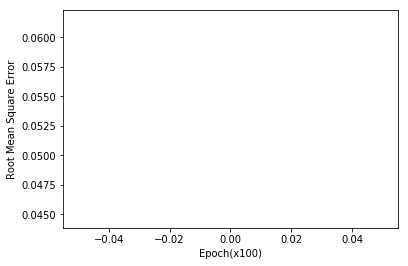

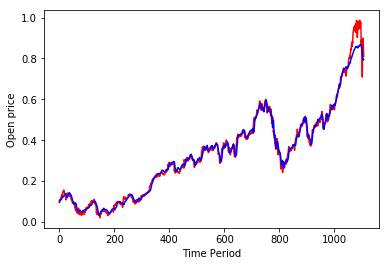

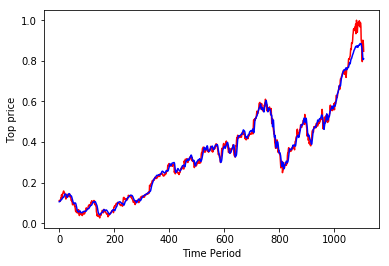

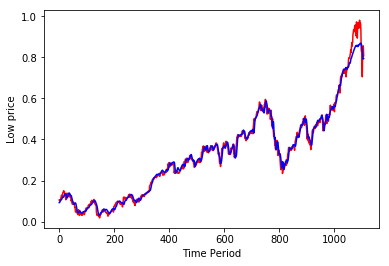

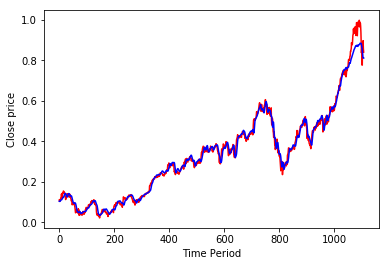

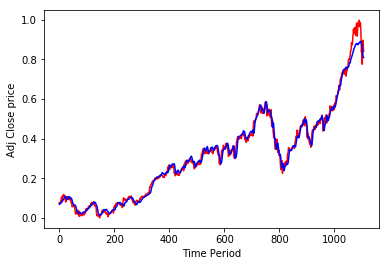

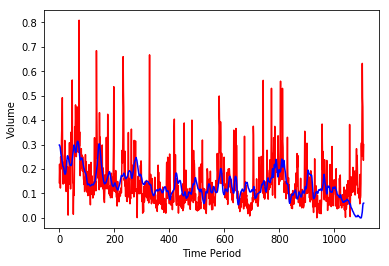

In [26]:
# 하이퍼파라미터 출력
print('input_data_column_cnt:', input_data_column_cnt, end='')
print(',output_data_column_cnt:', output_data_column_cnt, end='')

print(',seq_length:', seq_length, end='')
print(',rnn_cell_hidden_dim:', rnn_cell_hidden_dim, end='')
print(',forget_bias:', forget_bias, end='')
print(',num_stacked_layers:', num_stacked_layers, end='')
print(',keep_prob:', keep_prob, end='')

print(',epoch_num:', epoch_num, end='')
print(',learning_rate:', learning_rate, end='')

print(',train_error:', train_error_summary[-1], end='')
print(',test_error:', test_error_summary[-1], end='')
print(',min_test_error:', np.min(test_error_summary))

# 결과 그래프 출력
plt.figure(1)
plt.plot(train_error_summary, 'gold')
plt.plot(test_error_summary, 'b')
plt.xlabel('Epoch(x100)')
plt.ylabel('Root Mean Square Error')

plt.figure(2)
plt.plot(testY[:, [0]], 'r')
plt.plot(test_predict[:, [0]], 'b')
plt.xlabel('Time Period')
plt.ylabel('Open price')
plt.show()

plt.figure(3)
plt.plot(testY[:, [1]], 'r')
plt.plot(test_predict[:, [1]], 'b')
plt.xlabel('Time Period')
plt.ylabel('Top price')
plt.show()

plt.figure(4)
plt.plot(testY[:, [2]], 'r')
plt.plot(test_predict[:, [2]], 'b')
plt.xlabel('Time Period')
plt.ylabel('Low price')
plt.show()

plt.figure(5)
plt.plot(testY[:, [3]], 'r')
plt.plot(test_predict[:, [3]], 'b')
plt.xlabel('Time Period')
plt.ylabel('Close price')
plt.show()

plt.figure(6)
plt.plot(testY[:, [4]], 'r')
plt.plot(test_predict[:, [4]], 'b')
plt.xlabel('Time Period')
plt.ylabel('Adj Close price')
plt.show()

plt.figure(7)
plt.plot(testY[:, [5]], 'r')
plt.plot(test_predict[:, [5]], 'b')
plt.xlabel('Time Period')
plt.ylabel('Volume')
plt.show()